In [1]:
import ipywidgets as widgets

topo_path = widgets.Text(
    value = 'C:\\Users\\inst\\Documents\\GitHub\\image_segmentation\\data\\',
    placeholder='Type something',
    description='topo path:',
    disabled=False
)


vtk_path = widgets.Text(
    value = 'C:\\Users\\inst\\Documents\\GitHub\\image_segmentation\\data\\',
    placeholder='Type something',
    description='vtk path',
    disabled=False
)

display(topo_path)
display(vtk_path)


Text(value='C:\\Users\\inst\\Documents\\GitHub\\image_segmentation\\data\\', description='topo path:', placeho…

Text(value='C:\\Users\\inst\\Documents\\GitHub\\image_segmentation\\data\\', description='vtk path', placehold…

In [89]:
%matplotlib inline
import vtk
from vtk.numpy_interface import dataset_adapter as dsa
from scipy.optimize import minimize
from scipy.spatial import distance
import ipyvolume as ipv
import numpy as np
from skimage import io, filters
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy.ma as ma

pt_cloud_cyl = np.load(topo_path.value)

reader = vtk.vtkXMLImageDataReader()
reader.SetFileName(vtk_path.value)
reader.Update()

In [90]:
bin_num = 100
bins = np.linspace(np.min(pt_cloud_cyl[:,2]),np.max(pt_cloud_cyl[:,2]),bin_num)
z_index_s = np.digitize(pt_cloud_cyl[:,2],bins)
bin_index = np.unique(z_index_s)

In [91]:
binned_r = np.zeros((bin_num,3))

for i in bin_index:
    binned_r[i-1] = np.mean(pt_cloud_cyl[z_index_s==i],axis = 0)

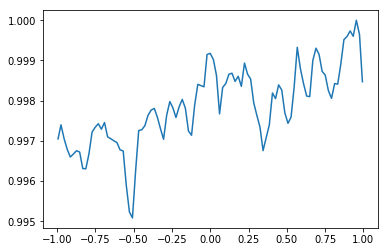

In [147]:
binned_normed = binned_r[:-1,:]
binned_normed[:,0] /= np.max(binned_normed[:,0])

fig, ax = plt.subplots()
ax.plot(binned_normed[:,2],binned_normed[:,0])
plt.show()

In [93]:
vtk_image = reader.GetOutput()
dim = vtk_image.GetDimensions()

In [120]:
wrapper = dsa.WrapDataObject(vtk_image)
np_array = wrapper.CellData['im'].reshape((dim[0]-1,dim[1]-1,dim[2]-1),order = 'F')

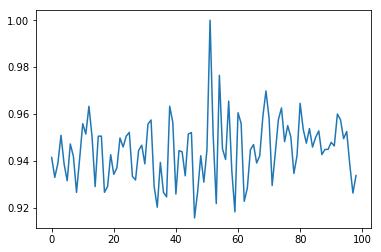

In [150]:
area = (1)**2*np.pi/(2e-3**2)

density_map = np.zeros(bin_num)
slab_size = int(np_array.shape[2]/bin_num)

for i in range(bin_num):
    if((slab_size*(i+1)) < np_array.shape[2]):
        density_map[i] = np.sum(np_array[slab_size*i:slab_size*(i+1),:,:])/(area*slab_size)*100
    else:
        diff = slab_size*i - np_array.shape[2]
        density_map[i] = np.sum(np_array[slab_size*i:,:,:])/(area*diff)*100

density_map_normed = density_map[:-1]
density_map_normed /= np.max(density_map_normed)
        
fig, ax = plt.subplots()
ax.plot(density_map_normed)
plt.show()


In [152]:
import scipy.stats as spt

chi, p = spt.chisquare(binned_normed[:,0],density_map_normed,1)

In [153]:
print(p)

1.0
